## Intent Classification

In [1]:
import os 
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv("./data/intent_dataset.csv")

In [3]:
dataset.sample(5)

,Unnamed: 0,text,intent
130,130,paisa tirne method ke ke cha,payment_method
139,139,ma ke ke tarika baata paisa tirna sakchu,payment_method
83,83,ma mero order kaile samma pauchu,order_status_inquiry
132,132,ma ke baata paisa tirna sakchu,payment_method
21,21,Casio calculator 9 items Kathmandu delivery lo...,order_product


In [4]:
dataset["text"].tolist()[:10]

['malai 5 ota Redmi ko mobile order garna man cha',
 'malai 1 ta Redmi ko mobile order garna man cha',
 'Apple ko Iphone 5 ota order garna man cha',
 'ma 2 ta Casio ko calculator order garxu',
 'mero order 1 ota Xiaomi ko Redmi mobile ho',
 'malai 9 ota Apple ko Iphone mobile Kathmandu ma delivery',
 '1 ota Sony ko TV, delivery location Dharan',
 '2 ota mobile, delivery location Sunsari',
 '1 ota calculator delivery location Dharan',
 '3 ta Sony ko TV delivery location Kathmandu']

In [5]:
dataset["text"] = dataset["text"].str.lower()

## Prepare data

In [6]:
import torch

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import dataloader

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [9]:
class IntentDataset(Dataset):
    """Intent classification dataset"""
    def __init__(self, dataset):
        self.X = dataset["text"].tolist()
        self.y = dataset["intent"].tolist()
        
        # bag of words
        self.vectorizer = CountVectorizer()
        self.bow_features = self.vectorizer.fit_transform(self.X).toarray()
        # label encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.y)
        
    def __len__(self):
        """Get the total length of the dataset"""
        return len(self.X)
    
    def __getitem__(self, index):
        """Get the item from the dataset"""
        bow_features = torch.tensor(self.bow_features[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return bow_features, label
    
    def get_labels(self):
        """Get all the labels"""
        return self.y.unique()
    
    def get_vocab_size(self):
        """Get vocab size"""
        return len(self.vectorizer.vocabulary_)
    
    def get_num_classes(self):
        """Get number of classes"""
        return len(self.label_encoder.classes_)
    
    def id2label(self, label):
        """mapping from id to label"""
        classes = self.label_encoder.classes_
        return classes[label]
        

In [10]:
intentDataset = IntentDataset(dataset)

In [11]:
len(intentDataset)

201

In [12]:
intentDataset[2]

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor(0))

In [13]:
intentDataset.id2label(1)

'order_status_inquiry'

In [14]:
intentDataset.bow_features.shape # total data with feature size

(201, 128)

## Data loader

In [15]:
train_dataloader = torch.utils.data.DataLoader(intentDataset, batch_size=8, shuffle=True)

## Model: Neural Network

In [16]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer_2 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer_3 = torch.nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.layer_1(x))
        out = self.relu(self.layer_2(out))
        out = self.layer_3(out)
        return out

## Model HyperParameters

In [17]:
input_size = intentDataset.get_vocab_size()
batch_size = 8
hidden_size = 20
num_classes = intentDataset.get_num_classes()
learning_rate = 0.001
num_epochs = 30

In [18]:
model = NeuralNetwork(input_size, hidden_size, num_classes)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
for i, x in enumerate(train_dataloader):
    if i == 0:
        print(x)
        break

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([2, 1, 0, 1, 2, 3, 2, 0])]


## Training Loop

In [21]:
loss_tracking = []

for epoch in range(num_epochs):
    loss_per_epoch = 0
    for i, (bow_features, labels) in enumerate(train_dataloader):
        logits = model(bow_features)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        loss_per_epoch += loss.item()
        
    loss_tracking.append(loss_per_epoch)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch: {epoch+1} and Loss: {loss.item()}")

print(f"Final Loss: {loss.item()}")

Epoch: 5 and Loss: 1.0875896215438843
Epoch: 10 and Loss: 0.13114473223686218
Epoch: 15 and Loss: 0.02218209207057953
Epoch: 20 and Loss: 0.053770408034324646
Epoch: 25 and Loss: 0.016969481483101845
Epoch: 30 and Loss: 0.0007309625507332385
Final Loss: 0.0007309625507332385


## Evaluation

In [22]:
model.eval()

NeuralNetwork(
  (layer_1): Linear(in_features=128, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=4, bias=True)
  (relu): ReLU()
)

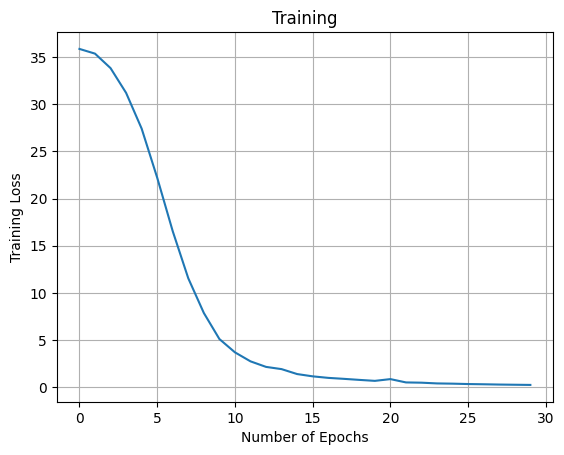

In [23]:
import matplotlib.pyplot as plt

epochs_range = np.arange(num_epochs)
plt.plot(epochs_range, loss_tracking)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.title("Training")
plt.grid(True)

## Inference

In [24]:
import json

In [25]:
with open("./data/replacement.json", "r") as f:
    file_data = json.load(f)

In [26]:
file_data

{'replacement': {'cha': ['chha', 'chhaa', 'xa', 'xha', 'xaa', 'x'],
  'malai': ['mlai', 'malaai', 'malae', 'molai', 'maalai', 'maalaai'],
  'kaha': ['kahaa', 'kah', 'kha', 'ka', 'khaa'],
  'baare': ['bare', 'baaree', 'barey', 'baarey'],
  'maile': ['mailee', 'mailey', 'mailei', 'maileey'],
  'ke': ['k'],
  'paryo': ['paro', 'pariyo', 'pario', 'parryo', 'parryoo'],
  'chahanchu': ['chaahanxu',
   'chahnxu',
   'chaahaanxu',
   'chaahanchu',
   'chaahaanchu'],
  'aaucha': ['auxa', 'aauxa', 'aauchha', 'auchha', 'axa'],
  'baata': ['bata', 'baat'],
  'milcha': ['milxa', 'milchha', 'milx'],
  'sakchu': ['sakxu', 'sakchhu', 'sakchhhu', 'sakchhuu'],
  'pauchu': ['pauxu', 'pauchhu', 'paauchhu', 'paauxu'],
  'laagcha': ['lagcha', 'laagchha', 'lagxa', 'lagx', 'laagxa']}}

In [27]:
replacement_keys = file_data["replacement"].values()
replacement_keys = [k for key in replacement_keys for k in key]
replacement_keys[:10]

['chha', 'chhaa', 'xa', 'xha', 'xaa', 'x', 'mlai', 'malaai', 'malae', 'molai']

In [28]:
replacement_values = list(file_data["replacement"].keys())
replacement_values

['cha',
 'malai',
 'kaha',
 'baare',
 'maile',
 'ke',
 'paryo',
 'chahanchu',
 'aaucha',
 'baata',
 'milcha',
 'sakchu',
 'pauchu',
 'laagcha']

In [29]:
mapping_key_value = dict()

for key, values in file_data["replacement"].items():
    new_key_value = {
        new_value: key for new_value in values
    }
    mapping_key_value.update(new_key_value)

In [30]:
mapping_key_value

{'chha': 'cha',
 'chhaa': 'cha',
 'xa': 'cha',
 'xha': 'cha',
 'xaa': 'cha',
 'x': 'cha',
 'mlai': 'malai',
 'malaai': 'malai',
 'malae': 'malai',
 'molai': 'malai',
 'maalai': 'malai',
 'maalaai': 'malai',
 'kahaa': 'kaha',
 'kah': 'kaha',
 'kha': 'kaha',
 'ka': 'kaha',
 'khaa': 'kaha',
 'bare': 'baare',
 'baaree': 'baare',
 'barey': 'baare',
 'baarey': 'baare',
 'mailee': 'maile',
 'mailey': 'maile',
 'mailei': 'maile',
 'maileey': 'maile',
 'k': 'ke',
 'paro': 'paryo',
 'pariyo': 'paryo',
 'pario': 'paryo',
 'parryo': 'paryo',
 'parryoo': 'paryo',
 'chaahanxu': 'chahanchu',
 'chahnxu': 'chahanchu',
 'chaahaanxu': 'chahanchu',
 'chaahanchu': 'chahanchu',
 'chaahaanchu': 'chahanchu',
 'auxa': 'aaucha',
 'aauxa': 'aaucha',
 'aauchha': 'aaucha',
 'auchha': 'aaucha',
 'axa': 'aaucha',
 'bata': 'baata',
 'baat': 'baata',
 'milxa': 'milcha',
 'milchha': 'milcha',
 'milx': 'milcha',
 'sakxu': 'sakchu',
 'sakchhu': 'sakchu',
 'sakchhhu': 'sakchu',
 'sakchhuu': 'sakchu',
 'pauxu': 'pauchu',
 

In [31]:
def preprocess_text(sentence):
    """Get the sentence and then correct the Roman Nepali text like cha xa chha to common"""
    replaced_text = ""
    for word in sentence.split():
        if word in replacement_keys:
            replaced_text = replaced_text + " " + mapping_key_value[word]
        else:
            replaced_text = replaced_text + " " + word
            
    return replaced_text.lower().strip()

In [32]:
sentence = "Ma kun kun method baata payment garna sakchu"
sentence = preprocess_text(sentence)
sentence

'ma kun kun method baata payment garna sakchu'

In [33]:
dataset_vectorize = intentDataset.vectorizer.transform([sentence]).toarray()
data_tensor = torch.tensor(dataset_vectorize, dtype=torch.float32)
data_tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [38]:
logits = model(data_tensor)
pred_prob = torch.softmax(logits, dim=-1)
assert pred_prob.sum(dim=1), "Softmax dimension error"
intent = intentDataset.id2label(torch.argmax(pred_prob, dim=-1))
intent

'payment_method'

## Classify 

In [43]:
def classify_intent(sentence: str) -> str:
    """Get the sentence and predict the any one of 4 intents"""
    preprocessed = preprocess_text(sentence)
    bow_sentence = intentDataset.vectorizer.transform([preprocessed]).toarray()
    bow_tensor = torch.tensor(bow_sentence, dtype=torch.float32)
    with torch.no_grad():
        pred = model(bow_tensor)
        pred = torch.softmax(pred, dim=1)
        pred_label = torch.argmax(pred, dim=1)
        
    predicted_intent = intentDataset.id2label(pred_label)
    return predicted_intent

In [40]:
intentDataset.label_encoder.classes_

array(['order_product', 'order_status_inquiry', 'payment_method',
       'product_inquiry'], dtype='<U20')

In [45]:
test_data = [
    "malai Redmi ko mobile order garnu xa",
    "malai naya saman order garnu xa",
    "mero order ko status ke xa",
    "ma kasari pay garna sakchu",
    "Samsung Galaxy ko barema bujhnu xa",
    "pasal ma k k saman xa"
]

In [47]:
for sentence in test_data:
    intent = classify_intent(sentence)
    print(f"{sentence}: <{intent.upper()}>")

malai Redmi ko mobile order garnu xa: <ORDER_PRODUCT>
malai naya saman order garnu xa: <ORDER_PRODUCT>
mero order ko status ke xa: <ORDER_STATUS_INQUIRY>
ma kasari pay garna sakchu: <PAYMENT_METHOD>
Samsung Galaxy ko barema bujhnu xa: <PRODUCT_INQUIRY>
pasal ma k k saman xa: <PRODUCT_INQUIRY>


## Save the model

In [48]:
torch.save(model.state_dict(), "./best.pt")